## 4D Tracking - Introduction
The LHCb will undergo an upgrade in 2030 (Upgrade-II) where the instantaneous luminosity will be 50 times the corresponding value during Run 2. The increased number of interactions per bunch crossing means that it important to identify the correct primary vertex to mantain the excellent vertex reconstruction so unique to the LHCb experiment. 


A possible solution to this problem is to add timing to the pixel detectors located inside the VELO. 

This will enable the correct primary vertex to be identified through the time stamping of hits that will allow the discrimination between hits with similar spatial coordinates.


However, pattern recongnition algorithms must first be developed that use the timing and spatial coordinates of the hits to reconstruct the tracks. 

$\textbf{The aim of this RAMP challenge is to find an algorithm that can reconstruct tracks with maximal efficiency and minimises the ghost and clone rates}$.

In [47]:
# Import the necessary packages 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy.cluster.hierarchy as shc
#%matplotlib widget
%matplotlib inline
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pickle 
import json 
import time 

### Read in the Data using Pandas
This example uses a smaller subset of hits as a demonstration of how to interact with the RAMP framework and submitting a solution. 
The ```RAMPData55microns50psInner200microns50psOuter_train.txt``` file could be used to train any machine learning based pattern recognition algorithm. 
The performance of any algorithm can be tested using the ```RAMPData55microns50psInner200microns50psOuter_test.txt``` file. This is also the file that the algorithm will be scored against.


If you haven't already done so, activate the the appropriate environment and download the data by running the commands below.

In [48]:
'''
Activate environment 
'''
# !conda env create -f environment.yml
# !conda activate ramp_velo_challenge

'''
Download Data 
'''

#!cd data
#!python ../download.py


'\nDownload Data \n'

In [49]:
df = pd.DataFrame()
df = pd.read_csv('data2/RAMPData55microns50psInner200microns50psOuter_train.txt', sep=' ')
#df = pd.read_csv('data/Data_test/RAMPData55microns50psInner200microns50psOuter_train.txt', sep=' ')


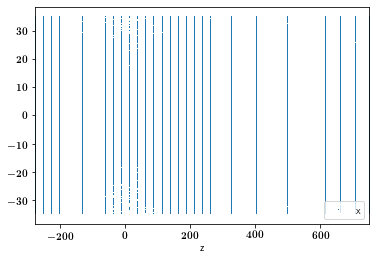

In [50]:
df.plot("z", "x", style=",")

In [51]:
'''
z = df['z'].unique()
dz=df['dz'].unique()

h = np.array([])
'''




"\nz = df['z'].unique()\ndz=df['dz'].unique()\n\nh = np.array([])\n"

In [52]:
'''
x = df['x'].unique()
y = df['y'].unique()
z = df['z'].unique()
dz=df['dz'].unique()
t = df['t'].unique()
hit = df['hit_id']

tmp = df[df['particle_id'] == 3719]

#plt.plot(z, dz)
plt.close('all')

#df.plot(x='x', y='y', style=',')
#df.plot(x='z', y='x', style=',')

#df.plot(x='z', y='y', style=',')

#df.plot(x='t', y='z', style=',')
#df.plot(x='t', y='x', style=',')
#df.plot(x='t', y='y', style=',')

df.plot(x='z' , y='hit_id', style=',' )
'''




"\nx = df['x'].unique()\ny = df['y'].unique()\nz = df['z'].unique()\ndz=df['dz'].unique()\nt = df['t'].unique()\nhit = df['hit_id']\n\ntmp = df[df['particle_id'] == 3719]\n\n#plt.plot(z, dz)\nplt.close('all')\n\n#df.plot(x='x', y='y', style=',')\n#df.plot(x='z', y='x', style=',')\n\n#df.plot(x='z', y='y', style=',')\n\n#df.plot(x='t', y='z', style=',')\n#df.plot(x='t', y='x', style=',')\n#df.plot(x='t', y='y', style=',')\n\ndf.plot(x='z' , y='hit_id', style=',' )\n"

In [53]:
df['particle_id'].unique().shape

(11110,)

### Splitting the Data
You may want to split the training sample to cross validate your algorithm. However, you can't split the sample randomly as the hits originating from the same track mu st be kept together. These functions will split the data such that the samples can be used to cross-validate the algorithm using the scoring function provided below. 

In [54]:
def Split_frac(df, frac):
    '''
    df: Dataframe that will be split
    
    frac: Fraction of data you want to run your algorithm over 
    '''
    
    # Maximum number of tracks 
    m = df['particle_id'].max()  
    split = int(frac*m)
    
    # Want to train algorithm using df1 and cross-validate using df2
    df1 = df.query(f'particle_id<{split}')
    df2 = df.query(f'particle_id>{split}')
    return df1, df2

def Split_N(df, n):
    '''
    n: Number of samples you want to split into 
    '''
    grouped = df.groupby(['particle_id'])
    group = np.array_split(grouped, n)
    df = []
    for j in range(n):
        # array of dataframes containing the split of the original data
        df.append(pd.concat([pd.DataFrame(group[j][i][1]) for i in range (len(group[j]))]))
    
    return df

#df_train = Split_N(df, 3)
df,_ = Split_frac(df,1)
df.shape

(72569, 10)

In [55]:
len(df), len(_)

(72569, 0)

### Developing an algorithm 
A numerical approach is utilised in this example. We use the angle $\phi$ of the hit, calculated by dividing the $x$ coordinate by the $y$ coordinate of the hit, to reconstruct tracks. Hits with similar angle $\phi$ are assigned to the same track.

In [56]:
df['r'] = pow(pow(df['x'],2)+pow(df['y'],2), 0.5) #automatically it add a new column to the data frame

# The angle phi can be between 0 and 2pi dependent on whether the x  
# and y coordinates are positive or negative.
conditions = [
    (df['x']<0) & (df['y']>0),
    (df['x']>0) & (df['y']<0),
    (df['x']<0) & (df['y']<0)
]

choices = [np.pi- np.arctan(abs(df['y']/df['x'])), 2*np.pi - np.arctan(abs(df['y']/df['x'])), np.pi+ np.arctan(abs(df['y']/df['x']))]
#df['phi'] = np.arctan(df['y']/df['x'])

df['phi']= np.select(conditions, choices, default=np.arctan(df['y']/df['x']) )
df['phi']= df['phi'].apply(lambda x: round(x, 3))
df.tail(10)
df['phi'].unique().shape

(6252,)

In [57]:
df.head()

,x,y,z,t,dx,dy,dz,dt,particle_id,hit_id,r,phi
0,-34.9999,-7.61119,-277,910.776,0.057735,0.057735,0.1,50.0,3719,0,35.817917,3.356
1,-34.9839,-9.90756,-252,991.861,0.057735,0.057735,0.1,50.0,2136,1,36.359772,3.418
2,-34.9831,9.22657,88,548.315,0.057735,0.057735,0.1,50.0,5848,2,36.179371,2.884
3,-34.9824,-33.29080,138,573.363,0.057735,0.057735,0.1,50.0,9020,3,48.291259,3.902
4,-34.9814,-21.58910,706,2432.890,0.057735,0.057735,0.1,50.0,5254,4,41.107026,3.695


In [ ]:
...................
........................
...............................
.......................................
...............................................
.............................................................

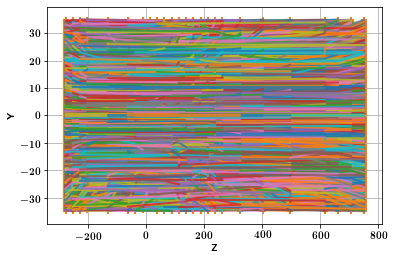

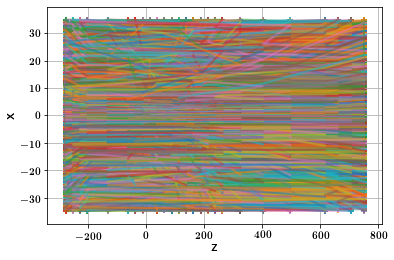

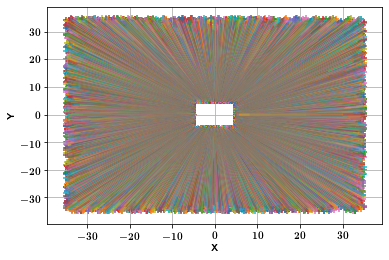

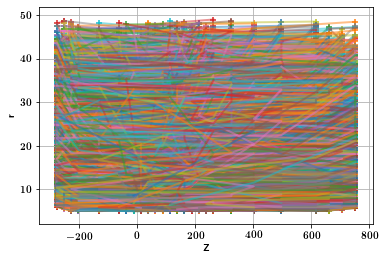

In [58]:
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']

# List will be used to create a text file 
tracks=[]
i=0
# Create plots to show the reconstructed tracks
plt.figure()
for vals in np.unique(df['phi'].values):
    data = df.query(f'(phi == {vals})')
    plt.plot(data['z'], data['y'], '-', alpha=0.8, lw=2)
    plt.scatter(df['z'], df['y'],       marker='+' )
    plt.xlabel(r"\textbf{Z}")
    plt.ylabel(r'\textbf{Y}')
    plt.grid(True)
    tracks.append(data['hit_id'])

# In the z-x plane
plt.figure()
for vals in np.unique(df['phi'].values):
    data = df.query(f'(phi == {vals})')
    plt.plot(data['z'], data['x'], '-', alpha=0.5, lw=2)
    plt.scatter(data['z'], data['x'],   marker='+' )
    plt.xlabel(r"\textbf{Z}")
    plt.ylabel(r'\textbf{X}')
    plt.grid(True)

plt.figure()
for vals in np.unique(df['phi'].values):
    data = df.query(f'(phi == {vals})')
    plt.plot(data['x'], data['y'], '-', alpha=0.5, lw=2)
    plt.scatter(data['x'], data['y'],   marker='+' )
    plt.xlabel(r"\textbf{X}")
    plt.ylabel(r'\textbf{Y}')
    plt.grid(True)
    
plt.figure()
for vals in np.unique(df['phi'].values):
    data = df.query(f'(phi == {vals})')
    plt.plot(   data['z'], data['r'], '-', alpha=0.5, lw=2)
    plt.scatter(data['z'], data['r'],   marker='+' )
    plt.xlabel(r"\textbf{Z}")
    plt.ylabel(r'\textbf{r}')
    plt.grid(True)


## Scoring 
Below is the function that will be used in the RAMP framework to provide the efficiency, clone rate and ghost rates of the submitted algorithm. You can test your algorithm against the scoring function and an example has been provided to assist you.

In [59]:
#df_tracks = pd.Series(np.asarray(v) for v in tracks)
df_tracks = df.groupby(['phi'])['hit_id'].unique()
df_tracks.head()

phi
0.000                         [60262, 75621, 83502, 85873]
0.001    [56441, 58262, 59994, 63646, 65425, 68403, 700...
0.002                  [66407, 71810, 76243, 79662, 81634]
0.003    [56959, 57306, 57695, 61854, 62057, 64237, 823...
0.004    [58517, 60518, 63311, 65957, 69192, 71996, 767...
Name: hit_id, dtype: object

In [60]:
def Scoring(particles, reconstructed_tracks):
    
    for a,b in zip(particles, df_tracks):
        # sort the arrays numerically
        a.sort()
        b.sort()

    good_tracks=0
    cloned=0
    # iterate over particles
    for particle in particles:
    # iterate over tracks reconstructed
        clones = 0
        for track in reconstructed_tracks:
            # check element wise equality between arrays 
            #if np.array_equal(particle, track):
            #   good_tracks=good_tracks+1
        
            if ((len(np.intersect1d(track, particle))/ len(particle))>=0.7):
                # np.intersect1d returns the sorted, unique values that are in both of the input arrays. 
                good_tracks=good_tracks+1  
                clones = clones+1
        if clones>1:
            cloned = cloned+(clones-1) 

    efficiency = good_tracks/len(particles)  
    fake = (len(reconstructed_tracks)-good_tracks)/len(reconstructed_tracks)
    clone_rate = cloned/len(reconstructed_tracks)
    return {'efficiency':efficiency, 'fake_rate':fake, 'clone_rate':clone_rate}

In [ ]:
df_real_tracks = df.groupby(['particle_id'])['hit_id'].unique()
print ('Scores for algorithm:')
t0 = time.time()
print (Scoring(df_real_tracks, df_tracks))
t = time.time()
duration = t-t0
print(f"the scoring time take{duration} seconds")

Scores for algorithm:


## Submitting a solution 

Once you are happy with the score of your algorithm, you can upload the list of Tracks, as well as the code you used to find the list of tracks. Remeber to apply your algorithm to the test data i.e. 

A naming convention needs to be followed when submitting your reconstructed Tracks. The name of the text file should begin with the detector configuration of the relevant dataset followed by your name i.e. for the dual technology dataset, the file could be called```55microns_50psInner_200microns_50psOuter_Name.txt```.

This file can be uploaded to the following link:
https://cernbox.cern.ch/index.php/s/y9riDHYUFUtGLRm

The code used to generate the reconstructed Tracks can be uploaded to the following link:
https://cernbox.cern.ch/index.php/s/QAYTsj9Wo9CLZVH
Remember to give your file an appropriate name which includes your name and the type of algorithm used i.e. ```Name_neural_network.py```

# My Solution 

First I will compute the theta and phi angles. 
Theta is the angle respecto to the z axis.
Phi is the angle on the detector layers. 
Rho is the distance of hit respect to z axis. 
r is the distance respecto to origin. 

Below I define polar coordinates in function of x,y,z.


In [ ]:
def rho(x,y):
    return np.sqrt(x*x + y*y)
def r(x,y,z):
    return np.sqrt(x*x + y*y + z*z)
def theta(x,y,z):
    return np.arccos(z/r(x,y,z))
def phi(x,y):
    return np.arctan(y/x)

Computing values ...

In [ ]:
#Redefining variables

df['r']     = pow(pow(df['x'],2)+pow(df['y'],2)+pow(df['z'],2), 0.5) 
df['rho']   = pow(pow(df['x'],2)+pow(df['y'],2), 0.5)

df['theta'] = df.apply(lambda row: theta(row['x'], row['y'], row['z'] ), axis=1)
df['phi']   = df.apply(lambda row: phi  (row['x'], row['y']),   axis=1)

In [ ]:
df.head()

# First Plots 

(It depends on the size of the data)
Now for simplicity sake I will work with 0.004 percent of the data as it is defined above 


In [ ]:
df.plot(x='t',y='z',color='red', style=',')

In [ ]:
df.plot(x='phi',y='theta',color='red', style=',')

In [ ]:
df.plot(x='t',y='phi',color='red', style=',')

In [ ]:
df.plot(x='z',y='theta',color='red', style=',')

In [ ]:
df.plot(x='x',y='y', style=',')

In [ ]:
df['x/rho'] = df.apply(lambda row: row['x']/row['rho'], axis=1)
df['y/rho'] = df.apply(lambda row: row['y']/row['rho'], axis=1)


df.plot(x='x/rho',y='y/rho', style=',')

In [ ]:
df['x/r'] = df.apply(lambda row: row['x']/row['r'], axis=1)
df['y/r'] = df.apply(lambda row: row['y']/row['r'], axis=1)


df.plot(x='x/r',y=r'y/r', style=',')

In [ ]:
df.plot(x='z',y='r', style=',')

In [ ]:
df.columns



In [ ]:
particle_id = df['particle_id'].values
theta = df['theta'].values
t = df['t'].values

In [ ]:
plt.plot(particle_id, theta,',')

# Second Plots.
# To Do in 3th week.

Calculate speed of particles from plot on slide 8 (z in cm, t in ps)

Make new version of plot on slide 8 with corrected time t_cor = t_hit - t_travel, where t_travel is the time
the particle takes to get from origin to the hit

## DoingTry 
### 2D algorithm grouping hits in (phi,eta)    [doing...]

Try 3D (phi, eta, t_cor)

Then try 3D with added requirement that no two hits on a track can have the same z value


For visualisations, try: For backward hits (z<0) redefine theta = pi-theta



In [ ]:
plt.plot(particle_id, t,',')

In [ ]:
df.plot(x='z',y='phi',color='red', style=',')

# Defining functions to solve 

Daniel Campora's Solution.
## Search by triplet(local method)
A fast local algorithm for track reconstruction on parallel architectures. 
Your solution is applied to above graphics. To enhace the algorithm I apply the same searching

1. Adaptation of trackforwarding techinique [to review ... ]



### Footnotes
Exist two kinds of methods:
1. local (extrapolation)
2. global (transformation)



In [ ]:
def sorbyphi():
    '''Description: 
    It sort the modules according to the number of modules
    '''
def findcandidatewindows():
    '''Description: '''
    
def trackseeding_trackforwarding():
    '''Description: '''
    
def trackforwarding():
    '''Description: '''
    
def trackseeding():
    '''Description: '''

def weaktrackfilter():
    '''Description: '''
    

# Questions or suppositions.

### Since particles suffer disperion when they across-in a module(layer), it is not correct to take the same angle to determine its tracks.

### 

In [ ]:
df['z'].unique()
df['phi'].unique()

# Characterization of tracks.

Dependencies about the ... ??? What ??? how should I improve the algorithm.
How? How. 

# Proofs and Drafts 

In [ ]:
df['z'].unique()

In [ ]:
variable = 1

tmp  = r'my first string{variable}'

print(tmp)

In [ ]:
df['Value'] = df.apply(lambda row: rho(row['x'], row['t']), axis=1)

In [ ]:
singlefunction = lambda row: rho(row['x'], row['t'])

In [ ]:
time.time

In [ ]:
import time

In [ ]:
time.time()

In [ ]:
df.columns

In [ ]:
df.head()

from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure().gca(projection='3d')
threedee.scatter(df['t'], df['theta'], df['phi'])
threedee.set_xlabesl('z')
threedee.set_ylabel('theta')
threedee.set_zlabel('phi')
plt.show()

In [ ]:
plt.show()

In [ ]:
len(df['particle_id'].unique()) # we have 555 particles from which we compute only 555 tracks. 

from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(df['x'], df['y'], df['z'], 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [ ]:
print(Scoring(df_real_tracks, df_tracks))

In [ ]:
df 